In [143]:
%matplotlib inline
#import matplotlib
#matplotlib.use('tkAgg')
import matplotlib.pyplot as plt
import sys
import math
import numpy as np
import scipy as sp
import scipy.optimize
import scipy.misc
import scipy.special

In [144]:
CAP = 15 * 10**8
S = -6.5

In [145]:
def issued(cummulative_euros):
    return np.floor(CAP * (1 - np.exp(S * cummulative_euros / CAP) ))

def frac(cummulative_euros):
    return issued(cummulative_euros) / issued(CAP)

def issuance(cummulative_euros):
    return scipy.misc.derivative(issued, cummulative_euros, dx=0.00001, n=1, order=7)

In [146]:
issuance(np.array([0.0, 10**8, CAP]))

array([  6.16666667e+04,   1.30385160e-03,  -1.49011612e-03])

In [147]:
issued(np.array([0.0, 10**8, CAP]))

array([  0.00000000e+00,   5.27483488e+08,   1.49774484e+09])

In [148]:
frac(np.array([0.0, 10**8, CAP]))

array([ 0.        ,  0.35218515,  1.        ])

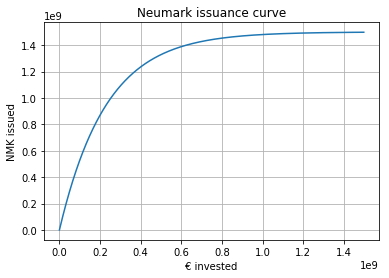

In [149]:
e = np.arange(0.0, CAP, CAP / 10**3)
n = np.floor(issued(e))
plt.plot(e, n)

plt.xlabel('€ invested')
plt.ylabel('NMK issued')
plt.title('Neumark issuance curve')
plt.grid(True)
plt.savefig("Issued.png")
plt.show()

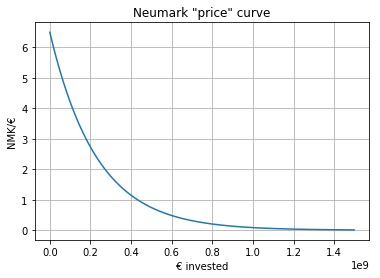

In [151]:
e = np.arange(1.0, CAP, CAP / 10**3)
n = - S * np.exp(S * e / CAP)
plt.plot(e, n)

plt.xlabel('€ invested')
plt.ylabel('NMK/€')
plt.title('Neumark "price" curve')
plt.grid(True)
plt.savefig("Issuance.png")
plt.show()

In [79]:
def ref_exp(k, n, d, e):
    '''Computes k · (1 - n / d)^e '''
    return k * (1 - n / d) ** e

def binomial_exp(k, n, d, e):
    '''Computes k · (1 - n / d)^e '''
    # https://ethereum.stackexchange.com/questions/10425/is-there-any-efficient-way-to-compute-the-exponentiation-of-a-fraction-and-an-in/10432
    s = 0
    N = 1
    B = 1 # Binomial coefficient
    for i in range(22):
        
        s += k * (N / B) * (-1)**i * ((n ** i) / (d ** i))
        
        # Update binomial fraction
        N = N * (e - i)
        B = B * (i + 1)
    
    return s

In [115]:
def nChoose(n):
    k = 0
    N = 1
    yield 1
    while k < n:
        N *= n - k
        k += 1
        N = N // k
        yield N

In [116]:
[x for x in nChoose(10)]

[1, 10, 45, 120, 210, 252, 210, 120, 45, 10, 1]

In [163]:
A = 1 - np.exp(S / CAP)
D = 2**54
N = int(np.round(A * D))

# Mathematica: round[ (1 - exp[ -65 / (15 * 10^9)  ]) * 2^64  ]
D = 2**64
N = 79935890813

# Mathematica: round[ (1 - exp[ -65 / (15 * 10^9)  ]) * 2^96  ]
D = 2**96
N = 343322036817947715929

# Mathematica: round[ (1 - exp[ -65 / (15 * 10^9)  ]) * 2^128  ]
#D = 2**128
#N = 1474556920129193345753962535832

def rescale(N, D):
    if (N | D) > 2**128:
        if (N | D) > 2**192:
            if ((N | D) > 2**224):
                N = N // 2**128
                D = D // 2**128
            else:
                N = N // 2**96
                D = D // 2**96
        else:
            if ((N | D) > 2**160):
                N = N // 2**64
                D = D // 2**64
            else:
                N = N // 2**32
                D = D // 2**32
    assert((N | D) <= 2**128)
    return N, D

def opt_exp(k, n, d, e):
    '''Computes k - k · (1 - n / d)^e '''
    i = 1
    j = e
    N = k
    s = 0
    while N > 0:
        N *= j
        assert(N < 2**256)
        N = N // i
        N *= n
        assert(N < 2**256)
        N = N // d
        if N == 0:
            break
        s += N
        i += 1
        j -= 1
        #print(N)
        
        N *= (e - i) * n
        i += 1
        N = N // i
        N = N // d
        #print(N)
        assert(N < 2**256)
        if N == 0:
            break
        s -= N
        i += 1
        j -= 1
            
    return s

def implementation(x):
    x = int(x)
    if x >= CAP:
        c = CAP 
    my = opt_exp(2**32 * CAP, N, D, x) // 2**32
    return my

In [164]:
implementation(10**9)

2989005874

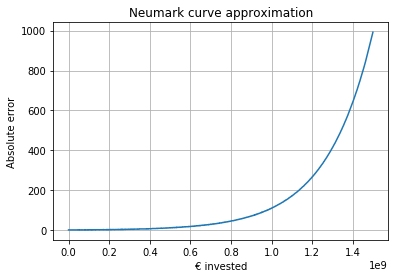

In [161]:
e = np.arange(1, CAP, CAP / 10**3)
i = np.array([implementation(x) for x in e])
a = np.floor(issued(e))
n = np.abs(i - a)
plt.plot(e, n)

plt.xlabel('€ invested')
plt.ylabel('Absolute error')
plt.title('Neumark curve approximation')
plt.grid(True)
plt.savefig("Issuance.png")
plt.show()

In [522]:
[A, N, D]

[4.3333333588080336e-09, 78062394, 18014398509481984]

In [523]:
previous = 0
for x in range(10**4):
    new = implementation(x)
    assert(new >= previous)
    previous = new

In [299]:
implementation(10**8)/implementation(CAP)

0.3521851501891406

In [628]:
implementation(135000001)

664341211

In [630]:
np.floor(issued(135000001))

664341210.0

In [549]:
664341210 # Wolfram alpha

664341210

In [577]:
N

78062394

In [581]:
78062393

78062393

In [579]:
S

-6.5

In [580]:
S/CAP

-4.333333333333333e-09

In [699]:
CAP

1500000000

In [737]:
[int(x) for x in 
issued(np.array(range(10)))]

[0, 6, 12, 19, 25, 32, 38, 45, 51, 58]

In [741]:
implementation(2)

12

In [767]:
[[x, int(issued(x))] for x in range(0, 10**1, 10**0)]

[[0, 0],
 [1, 6],
 [2, 12],
 [3, 19],
 [4, 25],
 [5, 32],
 [6, 38],
 [7, 45],
 [8, 51],
 [9, 58]]